In [2]:
import polars as pl
from classification_pipeline import cat_pipiline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

df = pl.read_parquet('../smalldata/classification.parquet')
df_prepared = cat_pipiline(df)
X_ = df_prepared.drop('cat__PlayType')
y_= df_prepared.select('cat__PlayType').to_numpy().ravel()

In [3]:
cat_cols = [x for x in X_.collect_schema().names() if "cat__" in x]

In [4]:
X_onehot=X_.to_dummies(cat_cols)

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state=5, n_jobs=-1)
from yellowbrick.classifier import ROCAUC

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_onehot, y_, test_size=0.25, random_state=42, shuffle=True
    ,stratify=y_
)
X_test, X_val, y_test, y_val=train_test_split(X_test, y_test, test_size=0.25, random_state=42, stratify=y_test)

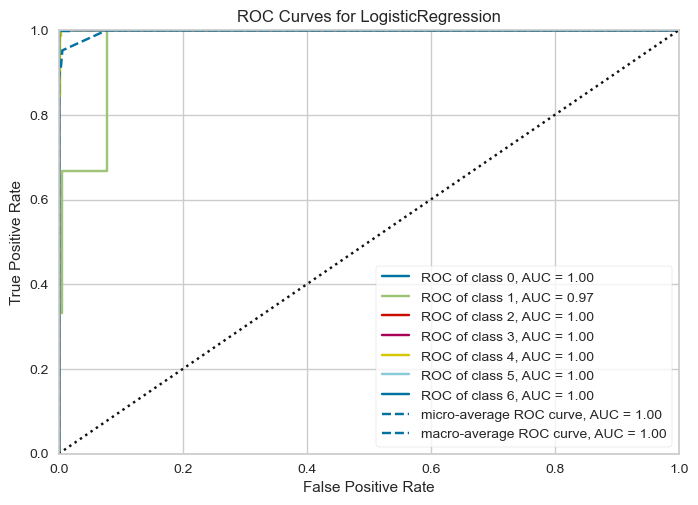

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [7]:
visualizer=ROCAUC(lr, per_class=True)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()

In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr, X_train, y_train, cv=3, scoring="accuracy")

array([0.9965338 , 0.99678058, 0.99603764])

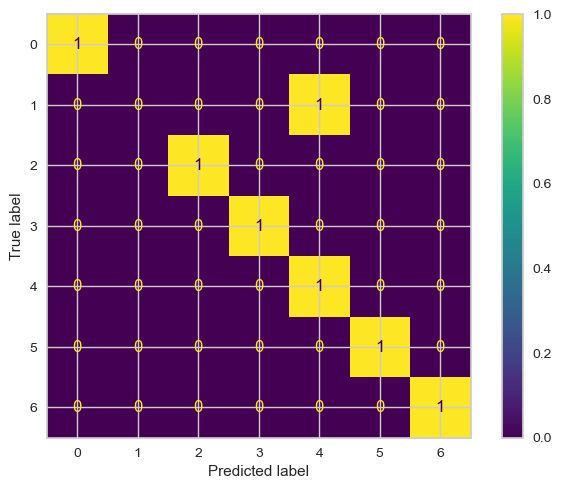

In [9]:
lr.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(lr, X_val, y_val, normalize='true')

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import gamma

distributions=dict(
    penalty=['l1', 'l2', 'elasticnet', 'none'],
    C=gamma(a=1, scale=1),
    solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    l1_ratio=gamma(a=1, scale=1)
)
clf=RandomizedSearchCV(lr, distributions, random_state=0, n_iter=10, cv=5, n_jobs=-1)
search=clf.fit(X_train, y_train)

search.best_params_

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning

{'C': 0.641694695602535,
 'l1_ratio': 0.2062032805354869,
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [11]:
lr.set_params(**search.best_params_)

LogisticRegression(C=0.641694695602535, l1_ratio=0.2062032805354869, n_jobs=-1,
                   penalty='elasticnet', random_state=5, solver='saga')

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


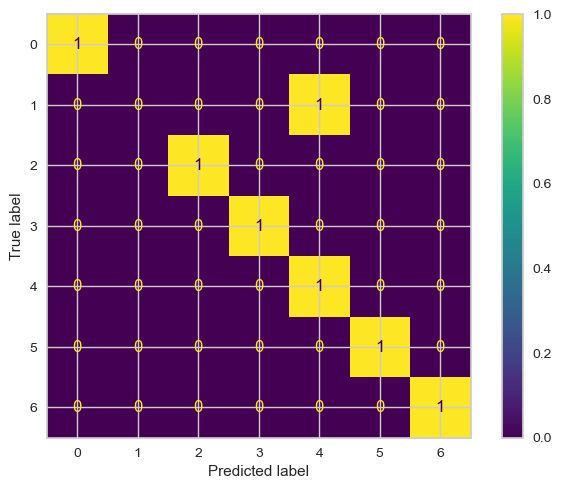

In [12]:
lr.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(lr, X_val, y_val, normalize='true')

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


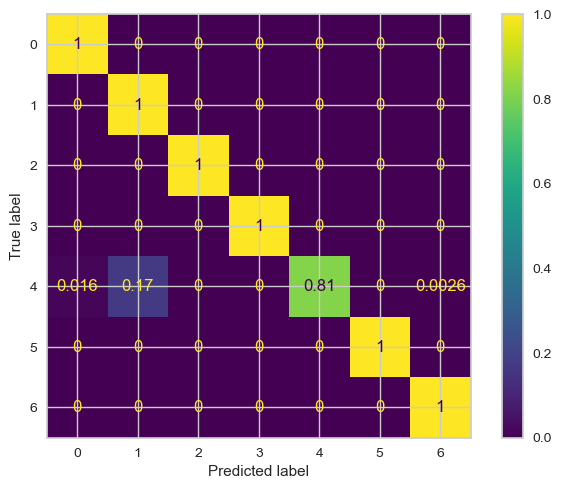

In [13]:
lr.set_params(class_weight="balanced")
lr.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(lr, X_val, y_val, normalize='true')

In [14]:
df = pl.read_parquet('../smalldata/classification.parquet')
df_prepared = cat_pipiline(df)
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=df_prepared.to_pandas(),
    table_name='BDB')

metadata.update_columns(
    column_names=['cat__possessionTeam',
                  'cat__defensiveTeam',
                  'cat__yardlineSide',
                  'cat__playNullifiedByPenalty',
                  'cat__receiverAlignment',
                  'cat__pff_runConceptPrimary',
                  'cat__pff_runConceptSecondary',
                  'cat__pff_passCoverage',
                  'cat__PenaltyType',
                  'cat__PenaltyTeam',
                  'cat__homeTeamAbbr',
                    'cat__visitorTeamAbbr'
                  ],
    sdtype='categorical'
)

from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df_prepared.to_pandas())

synthetic_data= synthesizer.sample(5000)


/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [15]:

synthetic_df = pl.DataFrame(synthetic_data)
synthetic_X = synthetic_df.drop('cat__PlayType')
synthetic_y = synthetic_df['cat__PlayType']
synthetic_X_onehot = synthetic_X.to_dummies(cat_cols)


In [17]:
lr.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(lr, synthetic_X, synthetic_y, normalize='true')

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- cat__City_Aaronhaven
- cat__City_Aaronmouth
- cat__City_Aaronport
- cat__City_Aaronside
- cat__City_Aaronstad
- ...
Feature names seen at fit time, yet now missing:
- cat__City_0
- cat__City_1
- cat__City_10
- cat__City_11
- cat__City_12
- ...
